<a href="https://colab.research.google.com/github/Joao-Victor-Leite/libras_CNN-RNN/blob/rnn/train_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalar dependências
!pip install numpy matplotlib tensorflow

In [ ]:
import os
import string
import sys
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# Caminho dos diretorios das amostras
cnn_path_data_train = '/content/drive/MyDrive/Academico/TCC/Projeto_alterado/dataset/cnn/train/'
cnn_path_data_test = '/content/drive/MyDrive/Academico/TCC/Projeto_alterado/dataset/cnn/test/'

static_letters = [letter for letter in string.ascii_uppercase if letter not in ['H', 'J', 'X', 'Y', 'Z']]

# Configurações globais
actions = np.array(sorted(os.listdir(cnn_path_data_train)))
EPOCHS = 200
FILE_NAME = 'cnn_model_'
LABEL_MAP = {label: num for num, label in enumerate(actions)}

In [ ]:
# Funções auxiliares
def get_log_filename():
    return str('cnn_model_{date:%d_%m_%Y_%H_%M}_log.log').format(date=datetime.datetime.now())

def get_date_str():
    return str('{date:%d_%m_%Y_%H_%M}').format(date=datetime.datetime.now())

def get_time_min(start, end):
    return (end - start)/60

def process_data(data_path):
    sequences, labels = [], []

    for action in actions:
        action_path = os.path.join(data_path, action)

        # Lista todos os arquivos .npy na pasta da ação (ex: A/)
        for frame_file in os.listdir(action_path):
            if frame_file.endswith('.npy'):
                # Carrega o arquivo .npy
                frame_path = os.path.join(action_path, frame_file)
                frame_data = np.load(frame_path)

                # Adiciona os dados e o rótulo
                sequences.append(frame_data)
                labels.append(LABEL_MAP[action])

    return np.array(sequences), to_categorical(labels).astype(int)

In [ ]:
# Execução principal
print("\n\n ----------------------INICIO --------------------------\n")
print('[INFO] [INICIO]: ' + get_date_str())

start = time.time()

# Processamento dos dados
print("[INFO] Processando os dados...")
X_train, y_train = process_data(cnn_path_data_train)
X_test, y_test = process_data(cnn_path_data_test)



 ----------------------INICIO --------------------------

[INFO] [INICIO]: 31_05_2025_04_04
[INFO] Processando os dados...


In [ ]:
print("Formato de X_train:", X_train.shape)
print("Formato de y_train:", y_train.shape)
print("Formato de X_test:", X_test.shape)
print("Formato de y_test:", y_test.shape)

Formato de X_train: (16800, 126)
Formato de y_train: (16800, 21)
Formato de X_test: (4200, 126)
Formato de y_test: (4200, 21)


In [ ]:
# Caminho para o diretório de logs
log_dir = '/content/drive/MyDrive/Academico/TCC/Projeto_alterado/logs'
os.makedirs(log_dir, exist_ok=True)

# Caminho completo para o arquivo de log
log_file_path = os.path.join(log_dir, get_log_filename())

# Redirecionar a saída padrão para o arquivo de log
sys.stdout = open(log_file_path, 'w')

# Configuração de callbacks
tb_callback = TensorBoard(log_dir=log_dir)

In [ ]:
# Definindo número de landmarks
num_landmarks = 21  # Ajuste conforme seu dataset
num_features = X_train.shape[1] // num_landmarks

# Redimensionamento dos dados
X_train = X_train.reshape(-1, num_landmarks, num_features)
X_test = X_test.reshape(-1, num_landmarks, num_features)

In [ ]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

In [ ]:
# Modelo 3 – CNN 1D Otimizada
model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(256, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.4),

    GlobalAveragePooling1D(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(len(actions), activation='softmax')
])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
checkpoint = ModelCheckpoint('best_model3.h5', monitor='val_categorical_accuracy', save_best_only=True, mode='max')

# Compilação
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

# Treinamento
print("\n[INFO] Treinando a CNN 1D...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=[tb_callback, early_stop, reduce_lr, checkpoint]
)

if os.path.exists('best_model3.h5'):
    os.remove('best_model3.h5')
    print("[INFO] Arquivo best_model3.h5 removido com sucesso.")
else:
    print("[INFO] Arquivo best_model3.h5 não encontrado para remoção.")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Registrar métricas de cada época
for epoch in range(len(history.history['loss'])):
    print(f"Epoch {epoch + 1}/{EPOCHS} - loss: {history.history['loss'][epoch]:.4f} - acc: {history.history['categorical_accuracy'][epoch]:.4f} - val_loss: {history.history['val_loss'][epoch]:.4f} - val_acc: {history.history['val_categorical_accuracy'][epoch]:.4f}")

In [ ]:
# Avaliação
print("\n[INFO] Avaliando a CNN...")
score = model.evaluate(X_test, y_test, verbose=1)
print(f"[INFO] Accuracy: {score[1] * 100:.2f}% | Loss: {score[0]:.5f}")

In [ ]:
# Salvamento do modelo
file_date = get_date_str()
model_path = f'/content/drive/MyDrive/Academico/TCC/Projeto_alterado/models/{FILE_NAME}{file_date}.h5'
model.save(model_path)
print(f'[INFO] Modelo salvo em: {model_path}')

end = time.time()
print("[INFO] CNN Runtime: %.1f min" % (get_time_min(start, end)))

In [ ]:
# Resumo do modelo
print('[INFO] Summary: ')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 21, 64)         │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 21, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 5, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 21)             │         2,709 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 486,145 (1.85 MB)

 Trainable params: 161,749 (631.83 KB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 323,500 (1.23 MB)

# Geração dos Graficos

In [ ]:
# Criação de diretórios para gráficos
os.makedirs('/content/drive/MyDrive/Academico/TCC/Projeto_alterado/models/graphics', exist_ok=True)
os.makedirs('/content/drive/MyDrive/Academico/TCC/Projeto_alterado/models/image', exist_ok=True)

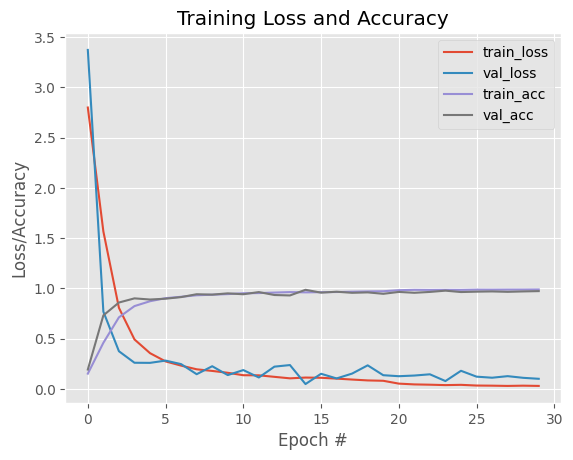

In [ ]:
# Gráficos de resultados
print("[INFO] Generating loss and accuracy graph")
plt.style.use("ggplot")
plt.figure()

num_epochs_trained = len(history.history["loss"])

plt.plot(np.arange(0, num_epochs_trained), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epochs_trained), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, num_epochs_trained), history.history["categorical_accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epochs_trained), history.history["val_categorical_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig(f'/content/drive/MyDrive/Academico/TCC/Projeto_alterado/models/graphics/{FILE_NAME}{file_date}.png', bbox_inches='tight')

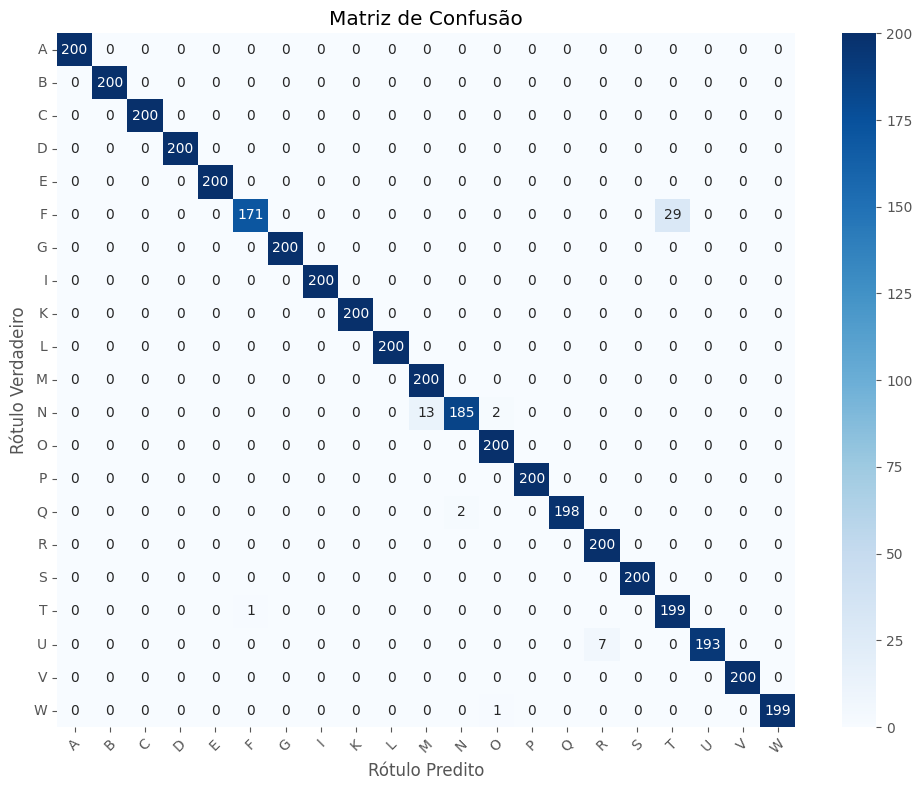

In [ ]:
from sklearn.metrics import classification_report, f1_score

# Gerar previsões para o conjunto de teste
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calcular F1-score
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"F1-score: {f1:.4f}")

# Gerar relatório completo
print(classification_report(y_true, y_pred_classes))

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plotar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=actions, yticklabels=actions)
plt.title('Matriz de Confusão')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Predito')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Salvar a imagem
confusion_matrix_path = f'/content/drive/MyDrive/Academico/TCC/Projeto_alterado/models/graphics/{FILE_NAME}{file_date}_confusion_matrix.png'
plt.savefig(confusion_matrix_path, bbox_inches='tight')
plt.show()

print(f"[INFO] Matriz de confusão salva em: {confusion_matrix_path}")

In [ ]:
# Plot da arquitetura do modelo
print('[INFO] Generating image of model architecture')
plot_model(model, to_file=f'/content/drive/MyDrive/Academico/TCC/Projeto_alterado/models/image/{FILE_NAME}{file_date}.png', show_shapes=True)

print('\n[INFO] [FIM]: ' + get_date_str())

# Fechar o arquivo de log
sys.stdout.close()
sys.stdout = sys.__stdout__  # Restaurar a saída padrão

print(f"[INFO] Log salvo em: {log_file_path}")